# 02_entrenamiento_modelos.ipynb

## Entrenamiento y evaluación de modelos
Este notebook entrena distintos modelos de regresión supervisada para predecir el precio final de una pieza plástica inyectada a partir de sus características técnicas. Los datos de entrenamiento provienen del archivo `piezas_con_precios.csv`
generado en `01_calculo_precios.ipynb`.

In [1]:
# Importar las librerías necesarias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV

### 1. Carga de datos
Se carga el conjunto de datos generado por el sistema automatizado con los precios ya calculados.

In [2]:
# Cargar el dataset 'piezas_con_precios.csv' generado en '01_calculo_precios.ipynb'.
df = pd.read_csv("piezas_con_precios.csv", sep=';')
df.head()

,referencia,descripcion,material,peso_(kg),tiempo_ciclo_(s),numero_cavidades,tonelaje_maquina,precio_final
0,REF001,Pieza A,PP UV,0.25,40,2,200,1.1465
1,REF002,Pieza B,ASA,0.50,45,2,350,2.9074
2,REF003,Pieza C,PC,0.75,50,1,500,4.1983
3,REF004,Pieza D,PP-TD20,0.15,35,4,150,0.7708
4,REF005,Pieza E,ABS,0.90,55,1,650,4.4737


### 2. Preprocesamiento
Separamos las variables predictoras (X) de la variable objetivo (precio_final), y aplicamos codificación one-hot sobre la variable categórica 'material'.

In [3]:
# Definicion de variables predictoras (X) y variable objetivo (y)
X = df.drop(columns=['referencia', 'descripcion', 'precio_final'])
y = df['precio_final']

# Aplicar One-hot encoding en 'material'
X_encoded = pd.get_dummies(X, columns=["material"])


### 3. División de datos
Dividimos el dataset en conjuntos de entrenamiento y prueba (80/20).

In [4]:
# Dividir los datos en train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

### 4. Entrenamiento y evaluación de modelos
Entrenamos tres modelos de regresión: Regresión Lineal, Random Forest y Gradient Boosting.

In [5]:
# Modelos
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42)
model_gb = GradientBoostingRegressor(random_state=42)

# Entrenamiento
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)

# Predicciones
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_gb = model_gb.predict(X_test)

# Evaluación
def evaluar(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'R2': r2_score(y_true, y_pred)
    }

resultados_iniciales = {
    'Regresion Lineal': evaluar(y_test, y_pred_lr),
    'Random Forest': evaluar(y_test, y_pred_rf),
    'Gradient Boosting': evaluar(y_test, y_pred_gb)
}

print("Resultados iniciales:")
df_resultados = pd.DataFrame(resultados_iniciales).T
df_resultados.columns = ["MAE", "RMSE", "R²"]
df_resultados

Resultados iniciales:


,MAE,RMSE,R²
Regresion Lineal,1.662585,2.158612,0.953189
Random Forest,1.536811,2.224744,0.950277
Gradient Boosting,1.335597,1.922762,0.962860


### 5. Búsqueda de hiperparámetros
Realizamos una busqueda de hiperparámetros para los modelos (Random Forest y Gradient Boosting)

In [6]:
# Random Forest
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Gradient Boosting
param_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 3, 5]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_gb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_gb.fit(X_train, y_train)


print('Mejores parámetros Random Forest:', grid_rf.best_params_)
print('Mejores parámetros Gradient Boosting:', grid_gb.best_params_)


Mejores parámetros Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Mejores parámetros Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}


### 6. Evaluación con los hiperparámetros
Evaluamos los modelos con los hiperparámetros

In [7]:
# Evaluación de los modelos optimizados
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

y_pred_rf_opt = best_rf.predict(X_test)
y_pred_gb_opt = best_gb.predict(X_test)

resultados_finales = {
    'Regresión Lineal': evaluar(y_test, y_pred_lr),
    'Random Forest (Optimizado)': evaluar(y_test, y_pred_rf_opt),
    'Gradient Boosting (Optimizado)': evaluar(y_test, y_pred_gb_opt)
}

print("Resultados después de la optimización:")
df_resultados_optimizados = pd.DataFrame(resultados_finales).T
df_resultados_optimizados.columns = ["MAE", "RMSE", "R²"]
df_resultados_optimizados



Resultados después de la optimización:


,MAE,RMSE,R²
Regresión Lineal,1.662585,2.158612,0.953189
Random Forest (Optimizado),1.575897,2.273468,0.948075
Gradient Boosting (Optimizado),1.388633,1.877599,0.964584


### 7. Visualización de resultados
Se grafican las métricas de evaluación para facilitar la comparación entre modelos.

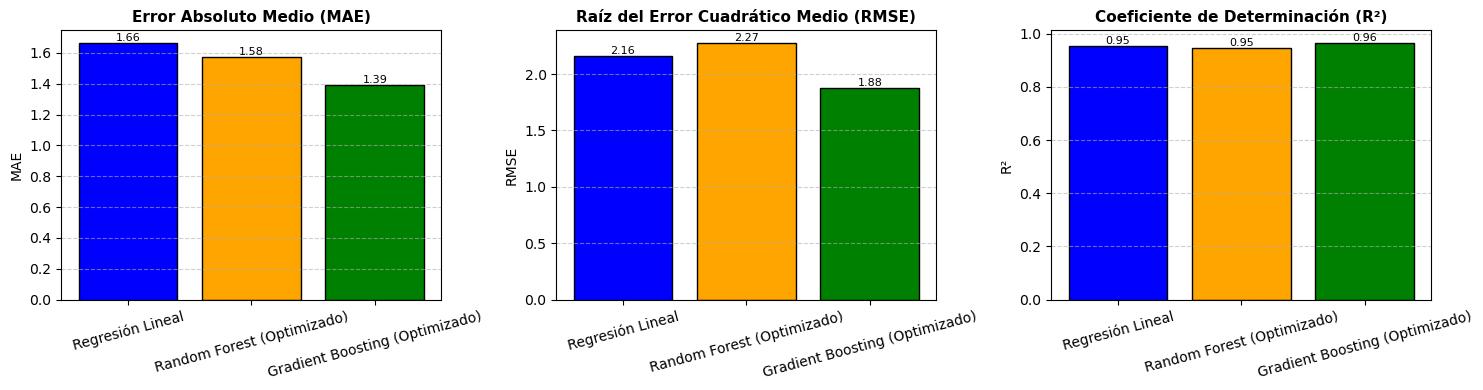

In [8]:
# Visualizar resultados
results_df = pd.DataFrame(resultados_finales).T.reset_index().rename(columns={'index': 'Modelo'})
results_df.columns = ['Modelo', 'MAE', 'RMSE', 'R²']

colors = ['blue', 'orange', 'green']
metricas = ['MAE', 'RMSE', 'R²']
titulos = ['Error Absoluto Medio (MAE)', 'Raíz del Error Cuadrático Medio (RMSE)', 'Coeficiente de Determinación (R²)']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes):
    metric = metricas[i]
    bars = ax.bar(results_df['Modelo'], results_df[metric], color=colors, edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    ax.set_title(titulos[i], fontsize=11, weight='bold')
    ax.set_ylabel(metric)
    ax.set_xticks(range(len(results_df['Modelo'])))
    ax.set_xticklabels(results_df['Modelo'], rotation=15)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### 8. Guardar el modelo elegido

In [9]:
# Guardar el modelo optimizado de Gradient Boosting
joblib.dump(grid_gb.best_estimator_, "modelo_gradient_boosting_optimizado.pkl")


['modelo_gradient_boosting_optimizado.pkl']